# Loading and Preprocessing Data with TensorFlow

# Setup

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tarfile
import urllib
from tensorflow.train import FloatList, Feature, Example
import tensorflow_transform as tft
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("ggplot")
warnings.filterwarnings(action="ignore")
os.chdir('datasets')

# The Data API

## Datasets

In [3]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

Equivalently:

In [4]:
dataset = tf.data.Dataset.range(10)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [5]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [6]:
dataset = dataset.map(lambda x: x * 2)
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [7]:
dataset = dataset.unbatch()
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(14, sh

In [8]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [9]:
dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 3 4 2 1 5 8], shape=(7,), dtype=int64)
tf.Tensor([6 9 7 2 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([6 0 7 9 0 1 2], shape=(7,), dtype=int64)
tf.Tensor([8 4 5 5 3 8 9], shape=(7,), dtype=int64)
tf.Tensor([7 6], shape=(2,), dtype=int64)


## Split the California dataset to multiple CSV files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [10]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [11]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [12]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [13]:
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Or in text mode:

In [14]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [15]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

## Building an Input Pipeline

In [16]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [17]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [18]:
f = lambda filepath: tf.data.TextLineDataset(filepath).skip(1)

In [19]:
n_readers = 5
dataset = filepath_dataset.interleave(f, cycle_length=n_readers)

In [20]:
for line in dataset.take(10):
    print(line.numpy())

b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418'
b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0'
b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67'
b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205'
b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215'
b'3.6548,29.0,4.6434540389972145,0.9916434540389972,2919.0,4.0654596100278555,34.3,-118.42,1.803'
b'3.9543,35.0,5.134122287968442,0.9506903353057199,1305.0,2.57396449704142,33.94,-118.0,2.144'
b'4.7426,19.0,5.871428571428571,1.022857142857143,1064.0,3.04,37.93,-121.66,2.631'
b'5.3344,12.0,7.594235033259423,1.2172949002217295,1357.0,3.008869179600887,38.58,-121.0,2.175'
b'4.4474,25.0,6.342776203966006,1.0226628895184136,928.0,2.6288951841359776,38.03,-122.26,2.037'


Notice that field 4 is interpreted as a string.

In [21]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Notice that all missing fields are replaced with their default value, when provided:

In [22]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

The 5th field is compulsory (since we provided `tf.constant([])` as the "default value"), so we get an exception if we do not provide it:

In [23]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


The number of fields should match exactly the number of fields in the `record_defaults`:

In [24]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


In [25]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [26]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [27]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [28]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [29]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [31]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [32]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10, verbose=0,
          validation_data=valid_set)

In [33]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 852us/step - loss: 0.4788


0.4787752032279968

In [34]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[2.3576405],
       [2.255291 ],
       [1.4437604],
       ...,
       [0.5654393],
       [3.9442453],
       [1.0232248]], dtype=float32)

In [35]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [36]:
keras.backend.clear_session()

In [37]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [38]:
keras.backend.clear_session()

In [39]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


Here is a short description of each method in the `Dataset` class:

In [40]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()      

# The Features API

In [41]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [42]:
fetch_housing_data()

In [43]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [44]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [45]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [46]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [47]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [48]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [49]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [50]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [51]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [52]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [53]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [54]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [55]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

### Using Feature Columns for Parsing

In [56]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [57]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [58]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=tf.train.Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [59]:
keras.backend.clear_session()

In [60]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

**Warning**: the `DenseFeatures` layer currently does not work with the Functional API, see [TF issue #27416](https://github.com/tensorflow/tensorflow/issues/27416). Hopefully this will be resolved before the final release of TF 2.0.

In [61]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
362/362 [==============================] - 0s 716us/step - loss: 3.9083 - accuracy: 0.0016
Epoch 2/5
362/362 [==============================] - 0s 702us/step - loss: 1.9228 - accuracy: 0.0020
Epoch 3/5
362/362 [==============================] - 0s 698us/step - loss: 1.4706 - accuracy: 0.0029
Epoch 4/5
362/362 [==============================] - 0s 698us/step - loss: 1.3730 - accuracy: 0.0035
Epoch 5/5
362/362 [==============================] - 0s 709us/step - loss: 1.3145 - accuracy: 0.0027


In [62]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -1.2252209 , -0.06296062],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -0.52398515,  0.84748596],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.52398515,  0.84748596]], dtype=float32)>

# TF Transform

In [63]:
def preprocess(inputs):  # inputs is a batch of input features
    median_age = inputs["housing_median_age"]
    ocean_proximity = inputs["ocean_proximity"]
    standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
    ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
    return {
        "standardized_median_age": standardized_age,
        "ocean_proximity_id": ocean_proximity_id
    }

# TensorFlow Datasets

In [64]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [65]:
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'esnli', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'i_naturalist2017', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imagenet_resized', 'imdb_reviews', 'iris'

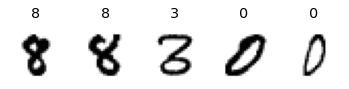

In [66]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [67]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[8 8 3 0 0 4 0 6 1 1 7 1 9 5 0 6 1 2 0 1 9 4 3 0 4 6 6 8 3 4 0 3]


In [68]:
keras.backend.clear_session()

In [69]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5, verbose=0)

# TensorFlow Hub

In [70]:
keras.backend.clear_session()

In [71]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [72]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [73]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       